In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
from tqdm import tqdm_notebook as tqdm
import codecs

from scipy.stats import ks_2samp

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import optuna
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# カラム名を英語に変更したもの 
train = pd.read_csv('./input/train_.csv', index_col=0)
test = pd.read_csv('./input/test_.csv', index_col=0)

df = pd.concat([train, test]).reset_index(drop=True)

train = df.loc[:len(train)-1, :]
test = df.loc[len(train):, :].drop(['rent'], axis=1)

# 外れ値

In [3]:
# 大きすぎる家賃
train = train[train['rent']<2000000]

# 建築年数が昔すぎる
train = train[(train['id']!=20428) & (train['id']!=20232)]

# 地価が低すぎる
train = train[train['id']!=20927]

# プロット時、何故か外れている
train = train[train['id']!=5776]
train = train[train['id']!=1772]

train.reset_index(drop=True, inplace=True)

# ハンドリング

In [4]:
df = pd.concat([train.drop(['rent'], axis=1), test]).reset_index(drop=True)

# 住所

In [5]:
address = df[['address']]

address = pd.DataFrame(address['address'].str[3:])

address['ward'] = address['address'].str.split('区').map(lambda x: x[0])
address['address_detail'] = address['address'].str.split('区').map(lambda x: x[1])

address['town'] = address['address_detail'].str.split('[０-９]').map(lambda x: x[0])
address['town'] = address['town'].apply(lambda x: re.sub('[0-9]', '', x))
address['town'] = address['town'].apply(lambda x: re.sub('丁目', '', x))
address['town'] = address['town'].apply(lambda x: re.sub('－', '', x))
address['town'] = address['town'].apply(lambda x: re.sub('-', '', x))

address['ward_town'] = address['ward'] + '_' + address['town']

address['ward_extra'] = np.where(address['ward'].isin(['港', '千代田', '中央']), 1, 0)

# 緯度経度

In [6]:
tmp = pd.read_csv('./input/lonlat.csv', index_col=0) # 外部データを取得
tmp['address'] = tmp['address'].str[3:]
address['address'] = address['address'].apply(lambda x: re.sub('１', '一', x))
address['address'] = address['address'].apply(lambda x: re.sub('２', '二', x))
address['address'] = address['address'].apply(lambda x: re.sub('３', '三', x))
address['address'] = address['address'].apply(lambda x: re.sub('４', '四', x))
address['address'] = address['address'].apply(lambda x: re.sub('５', '五', x))
address['address'] = address['address'].apply(lambda x: re.sub('６', '六', x))
address['address'] = address['address'].apply(lambda x: re.sub('７', '七', x))
address['address'] = address['address'].apply(lambda x: re.sub('８', '八', x))
address['address'] = address['address'].apply(lambda x: re.sub('９', '九', x))
address = address.merge(tmp, on='address', how='left')

# アクセス

In [7]:
access = df[['access']]
access['access'] = access['access'].apply(lambda x: re.sub('\(兵庫県\)', '', x))
access_origin = access['access']
access = access['access'].str.split('\t\t').apply(pd.Series).rename(columns={0:'access1' , 1: 'access2', 2: 'access3', 3: 'access4'})

access1 = access['access1'].str.split('\t').apply(pd.Series).rename(columns={0:'train1' , 1: 'station1', 2: 'time1'})
access2 = access['access2'].str.split('\t').apply(pd.Series).rename(columns={0:'train2' , 1: 'station2', 2: 'time2'})
access3 = access['access3'].str.split('\t').apply(pd.Series).rename(columns={0:'train3' , 1: 'station3', 2: 'time3'})

access = pd.concat([access_origin, access, access1, access2, access3], axis=1)

access['time1'] = access['time1'].fillna('').str[-5:-1].apply(lambda x: re.sub('\\D', '', x))
access.loc[access['time1']=='', 'time1'] = np.nan
access['time1'] = access['time1'].astype(float)

access['time2'] = access['time2'].fillna('').str[-5:-1].apply(lambda x: re.sub('\\D', '', x))
access.loc[access['time2']=='', 'time2'] = np.nan
access['time2'] = access['time2'].astype(float)

access['time3'] = access['time3'].fillna('').str[-5:-1].apply(lambda x: re.sub('\\D', '', x))
access.loc[access['time3']=='', 'time3'] = np.nan
access['time3'] = access['time3'].astype(float)

access['acccess1_bus_station'] = access.loc[access['access1'].str.contains('バス'), 'access1'].apply(lambda x: re.search(r"分.+徒歩", x).group(0) if re.search(r"分\).*徒歩", x) != None else np.nan)
access['acccess1_bus_station'] = access['acccess1_bus_station'].fillna('').apply(lambda x: re.sub('下車徒歩', '', x))
access['acccess1_bus_station'] = access['acccess1_bus_station'].fillna('').apply(lambda x: re.sub('分\)', '', x))
access['acccess1_bus_station'] = access['acccess1_bus_station'].fillna('').apply(lambda x: re.sub('（バス）', '', x))
access['acccess1_bus_station'] = access['acccess1_bus_station'].fillna('').apply(lambda x: re.sub('\u3000', '', x))

access['acccess1_bus_time'] = access.loc[access['access1'].str.contains('バス'), 'access1'].apply(lambda x: re.search(r"(?<=\().*?(?=\))",x).group(0))
access['acccess1_bus_time'] = access['acccess1_bus_time'].fillna('')
access['acccess1_bus_time'] = access['acccess1_bus_time'].apply(lambda x: re.sub('\\D', '', x))
access['acccess1_bus_time'] = access['acccess1_bus_time'].replace('', 0)
access['acccess1_bus_time'] = access['acccess1_bus_time'].astype(int)

access['acccess2_bus_station'] = access.loc[access['access2'].fillna('').str.contains('バス'), 'access2'].apply(lambda x: re.search(r"分.+徒歩", x).group(0) if re.search(r"分\).*徒歩", x) != None else np.nan)
access['acccess2_bus_station'] = access['acccess2_bus_station'].fillna('').apply(lambda x: re.sub('下車徒歩', '', x))
access['acccess2_bus_station'] = access['acccess2_bus_station'].fillna('').apply(lambda x: re.sub('分\)', '', x))
access['acccess2_bus_station'] = access['acccess2_bus_station'].fillna('').apply(lambda x: re.sub('（バス）', '', x))
access['acccess2_bus_station'] = access['acccess2_bus_station'].fillna('').apply(lambda x: re.sub('\u3000', '', x))

access['acccess2_bus_time'] = access.loc[access['access2'].fillna('').str.contains('バス'), 'access2'].apply(lambda x: re.search(r"(?<=\().*?(?=\))",x).group(0))
access['acccess2_bus_time'] = access['acccess2_bus_time'].fillna('')
access['acccess2_bus_time'] = access['acccess2_bus_time'].apply(lambda x: re.sub('\\D', '', x))
access['acccess2_bus_time'] = access['acccess2_bus_time'].replace('', 0)
access['acccess2_bus_time'] = access['acccess2_bus_time'].astype(int)

access['acccess3_bus_station'] = access.loc[access['access3'].fillna('').str.contains('バス'), 'access3'].apply(lambda x: re.search(r"分.+徒歩", x).group(0) if re.search(r"分\).*徒歩", x) != None else np.nan)
access['acccess3_bus_station'] = access['acccess3_bus_station'].fillna('').apply(lambda x: re.sub('下車徒歩', '', x))
access['acccess3_bus_station'] = access['acccess3_bus_station'].fillna('').apply(lambda x: re.sub('分\)', '', x))
access['acccess3_bus_station'] = access['acccess3_bus_station'].fillna('').apply(lambda x: re.sub('（バス）', '', x))
access['acccess3_bus_station'] = access['acccess3_bus_station'].fillna('').apply(lambda x: re.sub('\u3000', '', x))

access['acccess3_bus_time'] = access.loc[access['access3'].fillna('').str.contains('バス'), 'access3'].apply(lambda x: re.search(r"(?<=\().*?(?=\))",x).group(0) if re.search(r"(?<=\().*?(?=\))",x) != None else np.nan)
access['acccess3_bus_time'] = access['acccess3_bus_time'].fillna('')
access['acccess3_bus_time'] = access['acccess3_bus_time'].apply(lambda x: re.sub('\\D', '', x))
access['acccess3_bus_time'] = access['acccess3_bus_time'].replace('', 0)
access['acccess3_bus_time'] = access['acccess3_bus_time'].astype(int)

access['time1_total'] = access['time1'] + access['acccess1_bus_time']

access['time2_total'] = access['time2'] + access['acccess2_bus_time']

access['time3_total'] = access['time3'] + access['acccess3_bus_time']

access['time_total_mean'] = access[['time1_total', 'time2_total', 'time3_total']].mean(axis=1)
access['time_total_std'] = access[['time1_total', 'time2_total', 'time3_total']].std(axis=1)
access['time_total_max'] = access[['time1_total', 'time2_total', 'time3_total']].max(axis=1)
access['time_total_min'] = access[['time1_total', 'time2_total', 'time3_total']].min(axis=1)

access['time_mean'] = access[['time1', 'time2', 'time3']].mean(axis=1)
access['time_std'] = access[['time1', 'time2', 'time3']].std(axis=1)
access['time_max'] = access[['time1', 'time2', 'time3']].max(axis=1)
access['time_min'] = access[['time1', 'time2', 'time3']].min(axis=1)

access['access_count'] = access[['access1', 'access2', 'access3', 'access4']].isna().sum(axis=1)

access['bus'] = np.where(access['access'].str.contains('バス'), 1, 0)
access['repit_express'] = np.where((access['access'].str.contains('快速')) | (access['access'].str.contains('急行')), 1, 0)

access['trian'] = access['train1'] + '_' + access['train2'] + '_' + access['train3']
access['station'] = access['station1'] + '_' + access['station2'] + '_' + access['station3']

access['train_station1'] = access['train1'] + '_' + access['station1']
access['train_station2'] = access['train2'] + '_' + access['station2']
access['train_station3'] = access['train3'] + '_' + access['station3']

# 間取り

In [8]:
floor = df[['floor']]

floor_list = [
    'L', 'D', 'K', 'S', 'R', 
]

for l in floor_list:
    floor[l] = floor['floor'].str.contains(l).astype(float)
    
floor['floor_count'] = floor['floor'].apply(lambda x: re.sub('\\D', '', x))
floor['floor_trimmed'] = floor['floor'].apply(lambda x: re.sub('\+S\(納戸\)', '', x))

floor['floor_extra'] = np.where(floor['floor_trimmed'].isin(['5K', '5LDK', '6LDK', '4LDK', '3LDK']), 1, 0)

# 築年数

In [9]:
age = df[['age']]

age_ = age['age'].str.split('年').apply(pd.Series).rename(columns={0: 'year', 1: 'month'})

age_.loc[age_['month'].isnull(), 'year'] = 0

age_['month'] = age_['month'].fillna('0ヶ月').apply(lambda x: re.sub('ヶ月', '', x))

age_['year'] = age_['year'].astype(int)
age_['month'] = age_['month'].astype(int)

age_['month'] = age_['month'] / 12

age_['total_age'] = age_['year'] + age_['month']

age = pd.concat([age, age_], axis=1)

# 方向

In [10]:
direction = df[['direction']]

# 面積

In [11]:
area = df['area'].apply(lambda x: re.sub('m2', '', x)).astype(float)

# 階数

In [12]:
floor_num = df['floor_num']

floor_num = floor_num.str.split('／').apply(pd.Series)

floor_num = floor_num.fillna('no_data')

floor_num[0] = floor_num[0].apply(lambda x: re.sub('\\D', '', x))
floor_num.loc[floor_num[0]=='', 0] = np.nan
floor_num[0] = floor_num[0].astype(float)

floor_num[1] = floor_num[1].apply(lambda x: re.sub('\\D', '', x))
floor_num.loc[floor_num[1]=='', 1] = np.nan
floor_num[1] = floor_num[1].astype(float)

floor_num.columns = ['target_floor', 'total_floor']

floor_num['floor_rate'] = floor_num['target_floor'] / floor_num['total_floor']
floor_num['under_ground'] = df['floor_num'].str.contains('地下').astype(float)

floor_num = pd.concat([df['floor_num'], floor_num], axis=1)

# バス・トイレ

In [13]:
bathroom = df[['bathroom']]

bathroom_list = [
    '専用バス', '専用トイレ', 'バス・トイレ別', 'シャワー', '共同トイレ', 'バスなし', '共同バス', '追焚機能', '浴室乾燥機',
    '温水洗浄便座', '洗面台独立', '脱衣所', 'トイレなし', 
]

for l in bathroom_list:
    bathroom[l] = bathroom['bathroom'].str.contains(l).astype(float)
    
bathroom['bath_extra'] = np.where(
    (bathroom['bathroom']=='追焚機能') |
    (bathroom['bathroom']=='脱衣所') |
    (bathroom['bathroom']=='浴室乾燥機') |
    (bathroom['bathroom']=='温水洗浄便座') |
    (bathroom['bathroom']=='洗面台独立'),
    1, 0
)

bathroom['bath_minus'] = np.where(
    (bathroom['bathroom']=='共同トイレ') |
    (bathroom['bathroom']=='バスなし') |
    (bathroom['bathroom']=='共同バス'),
    1, 0
)

# キッチン

In [14]:
kitchen = df[['kitchen']]

kitchen_list = [
    'ガスコンロ', '給湯', 'コンロ2口', 'IHコンロ', 'コンロ3口', 'コンロ設置可', 'システムキッチン',
    '電気コンロ', 'コンロ1口', '冷蔵庫あり', 'カウンターキッチン', '独立キッチン', 'コンロ4口以上', 
    'L字キッチン', 
]

for l in kitchen_list:
    kitchen[l] = kitchen['kitchen'].str.contains(l).astype(float)
    
kitchen['kitchen_extra'] = np.where(
    (kitchen['kitchen']=='コンロ4口以上') |
    (kitchen['kitchen']=='コンロ設置可（コンロ4口以上）') |
    (kitchen['kitchen']=='L字キッチン'),
    1, 0
)

# 電波

In [15]:
wave = df[['wave']]

wave_list = [
    'インターネット対応', '光ファイバー', 'CATV', '高速インターネット', 'CSアンテナ', 'BSアンテナ', 'インターネット使用料無料', 
    '有線放送', 
]

for l in wave_list:
    wave[l] = wave['wave'].str.contains(l).astype(float)

# 設備

In [16]:
facility = df[['facility']]

facility_list = [
    'エアコン付', 'バルコニー', '冷房', 'シューズボックス', '床暖房', '公営水道', 'エレベーター', 'フローリング',
    '敷地内ごみ置き場', 'ウォークインクローゼット', '室内洗濯機置場', '床下収納', '2面採光', '都市ガス', '出窓', 'ロフト付き',
    'プロパンガス', '室外洗濯機置場', '石油暖房', 'トランクルーム', '洗濯機置場なし', 'タイル張り', 'クッションフロア',
    '24時間換気システム', '水道その他', 'ルーフバルコニー', 'ガス暖房', '下水', 'ペアガラス', '3面採光', '二重サッシ',
    'オール電化', '専用庭', '排水その他', '防音室', '地下室', '二世帯住宅', 'ガスその他', 'バリアフリー', '浄化槽', '汲み取り', 
    '井戸',
]

for l in facility_list:
    facility[l] = facility['facility'].str.contains(l).astype(float)

facility['facility_extra'] = np.where(
    (facility['facility']=='床暖房') |
    (facility['facility']=='トランクルーム') |
    (facility['facility']=='地下室') |
    (facility['facility']=='ルーフバルコニー') |
    (facility['facility']=='バリアフリー'),
    1, 0
)

facility['facility_minus'] = np.where(
    (facility['facility']=='ガスその他') |
    (facility['facility']=='室外洗濯機置場') |
    (facility['facility']=='洗濯機置場なし') |
    (facility['facility']=='プロパンガス') |
    (facility['facility']=='井戸'),
    1, 0
)

# 駐車場

In [17]:
def eval_parking(str):
    parking_strs = ['', '', '']
    if np.nan == str:
        return parking_strs
    
    str_non_comma = str.replace(',', '')
    
    result = re.split('駐輪場|バイク置き場|駐車場', str_non_comma)
    
    items = ['駐輪場', 'バイク置き場', '駐車場']
    indices = []
    for item in items:
        index = str.find(item)
        if index == -1:
            continue
        indices.append(str.find(item))
        
    indices = np.array(indices).argsort()
    for i, index in enumerate(indices):
        parking_strs[i] = result[index + 1]
        
    return parking_strs

In [18]:
parking = df[['parking']]

tmp = parking.fillna('')
for s in ['駐輪場', 'バイク置き場', '駐車場']:
    tmp.loc[~tmp['parking'].str.contains(s), 'parking'] = tmp['parking'] + '\t' + s

tmp = tmp.dropna()
tmp = tmp['parking'].map(lambda x: eval_parking(x))
tmp = tmp.apply(pd.Series).rename(columns={0: 'bike', 1: 'motorcycle', 2: 'car'})
tmp = tmp.replace('\t', '')

bike = tmp[['bike']]
motorcycle = tmp[['motorcycle']]
car = tmp[['car']]

bike = pd.DataFrame(bike['bike'].str.lstrip('\t'))
bike = pd.DataFrame(bike['bike'].str.rstrip('\t'))
bike['bike_true'] = bike['bike'].str.contains('有').astype(int)
bike['bike_false'] = bike['bike'].str.contains('無').astype(int)
bike['bike_neighborhood'] = bike['bike'].str.contains('近隣').astype(int)
bike['bike_price'] = bike['bike'].apply(lambda x: max(re.findall('(\d+)円', x)) if len(re.findall('(\d+)円', x))!=0 else np.nan).astype(float)
bike['bike_dist'] = bike['bike'].apply(lambda x: max(re.findall('(\d+)m', x)) if len(re.findall('(\d+)m', x))!=0 else np.nan).astype(float)

motorcycle = pd.DataFrame(motorcycle['motorcycle'].str.lstrip('\t'))
motorcycle = pd.DataFrame(motorcycle['motorcycle'].str.rstrip('\t'))
motorcycle['motorcycle_true'] = motorcycle['motorcycle'].str.contains('有').astype(int)
motorcycle['motorcycle_false'] = motorcycle['motorcycle'].str.contains('無').astype(int)
motorcycle['motorcycle_neighborhood'] = motorcycle['motorcycle'].str.contains('近隣').astype(int)
motorcycle['motorcycle_price'] = motorcycle['motorcycle'].apply(lambda x: max(re.findall('(\d+)円', x)) if len(re.findall('(\d+)円', x))!=0 else np.nan).astype(float)
motorcycle['motorcycle_dist'] = motorcycle['motorcycle'].apply(lambda x: max(re.findall('(\d+)m', x)) if len(re.findall('(\d+)m', x))!=0 else np.nan).astype(float)

car = pd.DataFrame(car['car'].str.lstrip('\t'))
car = pd.DataFrame(car['car'].str.rstrip('\t'))
car['car_true'] = car['car'].str.contains('有').astype(int)
car['car_false'] = car['car'].str.contains('無').astype(int)
car['car_neighborhood'] = car['car'].str.contains('近隣').astype(int)
car['car_price'] = car['car'].apply(lambda x: max(re.findall('(\d+)円', x)) if len(re.findall('(\d+)円', x))!=0 else np.nan).astype(float)
car['car_dist'] = car['car'].apply(lambda x: max(re.findall('(\d+)m', x)) if len(re.findall('(\d+)m', x))!=0 else np.nan).astype(float)

parking = pd.concat([parking, bike, motorcycle, car], axis=1).replace('', np.nan)

# 環境情報

In [19]:
environment = df[['environment']]

environment_list = [
    '小学校', 'スーパー', 'ドラッグストア', 'コンビニ', '大学', '郵便局', '幼稚園・保育園', '飲食店', '学校',
    '公園', 'デパート', '病院', 'レンタルビデオ', '総合病院', '銀行', '図書館', '月極駐車場', 'クリーニング', 
    'コインパーキング',
]

tmp = pd.DataFrame()

for l in environment_list:
    tmp[l] = environment['environment'].fillna('') + '【{}】 99999 【'.format(l)
    tmp[l] = tmp[l].apply(lambda x: min(re.findall('【{}】 (\d+)'.format(l), x)))
    tmp[l] = tmp[l].astype(float)
    tmp[l] = tmp[l].replace(99999, np.nan)

environment = pd.concat([environment, tmp], axis=1)
environment[''] = environment['environment'].str.count('【')

# 構造

In [20]:
building = df[['building']]

building['building_extra'] = np.where(
    (building['building']=='SRC（鉄骨鉄筋コンクリート）') |
    (building['building']=='RC（鉄筋コンクリート）'),
    1, 0
)

building['building_minus'] = np.where(building['building']=='ブロック', 1, 0)

# 契約期間

In [21]:
period = df[['period']]

period['定期借家'] = period['period'].str.contains('定期借家').astype(float)

period['period'] = period['period'].fillna('no_data')
period['period'] = pd.DataFrame(period['period'].str.split('\t').map(lambda x: x[0]))

period['period_util'] = np.nan
period.loc[period['period'].str.contains('まで'), 'period_util'] = period['period']
period.loc[period['period'].str.contains('まで'), 'period'] = 'no_data'

period.loc[~period['period'].str.contains('年'), 'period'] = '0年' + period['period']
period.loc[period['period'].str.contains('no_data'), 'period'] = 'no_data'

tmp = period['period'].str.split('年').apply(pd.Series)

tmp[0] = tmp[0].apply(lambda x: re.sub('\\D', '', x))
tmp.loc[tmp[0]=='', 0] = np.nan
tmp[0] = tmp[0].astype(float)

tmp[1] = tmp[1].fillna('no_data')
tmp[1] = tmp[1].apply(lambda x: re.sub('\\D', '', x))
tmp.loc[tmp[1]=='', 1] = np.nan
tmp[1] = tmp[1].astype(float)

tmp[1] = tmp[1] / 12

tmp = tmp.fillna(0)
tmp[2] = tmp[0] + tmp[1]

tmp = tmp.replace(0, np.nan)
tmp.columns = ['period_year', 'period_month', 'period_total']
period = pd.concat([period, tmp], axis=1)
period = period.replace('no_data', np.nan)

# 変数追加

In [22]:
df_ = pd.concat([
    address, 
    access, 
    floor,
    age,
    direction,
    area,
    floor_num,
    bathroom,
    kitchen,
    wave,
    facility,
    parking,
    environment,
    building,
    period,
], axis=1)

df_ = df_.replace('', np.nan)

In [23]:
train = pd.concat([df_.iloc[:len(train), :], train['rent']], axis=1)

test = df_.iloc[len(train):, :]

In [24]:
# 交差項
for feature in ['address__floor_trimmed', 'ward__floor_trimmed', 'town__floor_trimmed', 'ward_town__floor_trimmed', 'building__floor_trimmed',]:
    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

In [25]:
col_list = ['address', 'ward', 'town', 'address_detail', 'ward_town']

for col in col_list:
    train['total_age_mean_{}'.format(col)] = train.groupby([col])['total_age'].transform('mean')
    train['total_age_std_{}'.format(col)] = train.groupby([col])['total_age'].transform('std')
    train['total_age_max_{}'.format(col)] = train.groupby([col])['total_age'].transform('max')
    train['total_age_min_{}'.format(col)] = train.groupby([col])['total_age'].transform('min')
    train['total_age_to_mean_{}'.format(col)] = train['total_age'] / train['total_age_mean_{}'.format(col)]
    train['total_age_to_std_{}'.format(col)] = train['total_age'] / train['total_age_std_{}'.format(col)]
    train['total_age_to_max_{}'.format(col)] = train['total_age'] / train['total_age_max_{}'.format(col)]
    train['total_age_to_min_{}'.format(col)] = train['total_age'] / train['total_age_min_{}'.format(col)]

    test['total_age_mean_{}'.format(col)] = test.groupby([col])['total_age'].transform('mean')
    test['total_age_std_{}'.format(col)] = test.groupby([col])['total_age'].transform('std')
    test['total_age_max_{}'.format(col)] = test.groupby([col])['total_age'].transform('max')
    test['total_age_min_{}'.format(col)] = test.groupby([col])['total_age'].transform('min')
    test['total_age_to_mean_{}'.format(col)] = test['total_age'] / test['total_age_mean_{}'.format(col)]
    test['total_age_to_std_{}'.format(col)] = test['total_age'] / test['total_age_std_{}'.format(col)]
    test['total_age_to_max_{}'.format(col)] = test['total_age'] / test['total_age_max_{}'.format(col)]
    test['total_age_to_min_{}'.format(col)] = test['total_age'] / test['total_age_min_{}'.format(col)]

In [26]:
col_list = ['address', 'ward', 'town', 'address_detail', 'ward_town']

for col in col_list:
    train['total_floor_mean_{}'.format(col)] = train.groupby([col])['total_floor'].transform('mean')
    train['total_floor_std_{}'.format(col)] = train.groupby([col])['total_floor'].transform('std')
    train['total_floor_max_{}'.format(col)] = train.groupby([col])['total_floor'].transform('max')
    train['total_floor_min_{}'.format(col)] = train.groupby([col])['total_floor'].transform('min')
    train['total_floor_to_mean_{}'.format(col)] = train['total_floor'] / train['total_floor_mean_{}'.format(col)]
    train['total_floor_to_std_{}'.format(col)] = train['total_floor'] / train['total_floor_std_{}'.format(col)]
    train['total_floor_to_max_{}'.format(col)] = train['total_floor'] / train['total_floor_max_{}'.format(col)]
    train['total_floor_to_min_{}'.format(col)] = train['total_floor'] / train['total_floor_min_{}'.format(col)]

    test['total_floor_mean_{}'.format(col)] = test.groupby([col])['total_floor'].transform('mean')
    test['total_floor_std_{}'.format(col)] = test.groupby([col])['total_floor'].transform('std')
    test['total_floor_max_{}'.format(col)] = test.groupby([col])['total_floor'].transform('max')
    test['total_floor_min_{}'.format(col)] = test.groupby([col])['total_floor'].transform('min')
    test['total_floor_to_mean_{}'.format(col)] = test['total_floor'] / test['total_floor_mean_{}'.format(col)]
    test['total_floor_to_std_{}'.format(col)] = test['total_floor'] / test['total_floor_std_{}'.format(col)]
    test['total_floor_to_max_{}'.format(col)] = test['total_floor'] / test['total_floor_max_{}'.format(col)]
    test['total_floor_to_min_{}'.format(col)] = test['total_floor'] / test['total_floor_min_{}'.format(col)]

In [27]:
col_list = ['address', 'ward', 'town', 'address_detail', 'ward_town']

for col in col_list:
    train['スーパー_mean_{}'.format(col)] = train.groupby([col])['スーパー'].transform('mean')
    train['スーパー_std_{}'.format(col)] = train.groupby([col])['スーパー'].transform('std')
    train['スーパー_to_mean_{}'.format(col)] = train['スーパー'] / train['スーパー_mean_{}'.format(col)]
    train['スーパー_to_std_{}'.format(col)] = train['スーパー'] / train['スーパー_std_{}'.format(col)]

    test['スーパー_mean_{}'.format(col)] = test.groupby([col])['スーパー'].transform('mean')
    test['スーパー_std_{}'.format(col)] = test.groupby([col])['スーパー'].transform('std')
    test['スーパー_to_mean_{}'.format(col)] = test['スーパー'] / test['スーパー_mean_{}'.format(col)]
    test['スーパー_to_std_{}'.format(col)] = test['スーパー'] / test['スーパー_std_{}'.format(col)]

In [28]:
col_list = ['address', 'ward', 'town', 'address_detail', 'ward_town']

for col in col_list:
    train['コンビニ_mean_{}'.format(col)] = train.groupby([col])['コンビニ'].transform('mean')
    train['コンビニ_std_{}'.format(col)] = train.groupby([col])['コンビニ'].transform('std')
    train['コンビニ_to_mean_{}'.format(col)] = train['コンビニ'] / train['コンビニ_mean_{}'.format(col)]
    train['コンビニ_to_std_{}'.format(col)] = train['コンビニ'] / train['コンビニ_std_{}'.format(col)]

    test['コンビニ_mean_{}'.format(col)] = test.groupby([col])['コンビニ'].transform('mean')
    test['コンビニ_std_{}'.format(col)] = test.groupby([col])['コンビニ'].transform('std')
    test['コンビニ_to_mean_{}'.format(col)] = test['コンビニ'] / test['コンビニ_mean_{}'.format(col)]
    test['コンビニ_to_std_{}'.format(col)] = test['コンビニ'] / test['コンビニ_std_{}'.format(col)]

In [29]:
col_list = ['address', 'ward', 'town', 'address_detail', 'ward_town']

for col in col_list:
    train['time_total_mean_mean_{}'.format(col)] = train.groupby([col])['time_total_mean'].transform('mean')
    train['time_total_mean_std_{}'.format(col)] = train.groupby([col])['time_total_mean'].transform('std')
    train['time_total_mean_to_mean_{}'.format(col)] = train['time_total_mean'] / train['time_total_mean_mean_{}'.format(col)]
    train['time_total_mean_to_std_{}'.format(col)] = train['time_total_mean'] / train['time_total_mean_std_{}'.format(col)]

    test['time_total_mean_mean_{}'.format(col)] = test.groupby([col])['time_total_mean'].transform('mean')
    test['time_total_mean_std_{}'.format(col)] = test.groupby([col])['time_total_mean'].transform('std')
    test['time_total_mean_to_mean_{}'.format(col)] = test['time_total_mean'] / test['time_total_mean_mean_{}'.format(col)]
    test['time_total_mean_to_std_{}'.format(col)] = test['time_total_mean'] / test['time_total_mean_std_{}'.format(col)]

In [30]:
col_list = ['address', 'ward', 'town', 'address_detail', 'ward_town',
            'floor_trimmed', 'ward__floor_trimmed', 'town__floor_trimmed', 'ward_town__floor_trimmed', 'station']

for col in col_list:
    train['area_mean_{}'.format(col)] = train.groupby([col])['area'].transform('mean')
    train['area_std_{}'.format(col)] = train.groupby([col])['area'].transform('std')
    train['area_max_{}'.format(col)] = train.groupby([col])['area'].transform('max')
    train['area_min_{}'.format(col)] = train.groupby([col])['area'].transform('min')
    train['area_to_mean_{}'.format(col)] = train['area'] / train['area_mean_{}'.format(col)]
    train['area_to_std_{}'.format(col)] = train['area'] / train['area_std_{}'.format(col)]
    train['area_to_max_{}'.format(col)] = train['area'] / train['area_max_{}'.format(col)]
    train['area_to_min_{}'.format(col)] = train['area'] / train['area_min_{}'.format(col)]

    test['area_mean_{}'.format(col)] = test.groupby([col])['area'].transform('mean')
    test['area_std_{}'.format(col)] = test.groupby([col])['area'].transform('std')
    test['area_max_{}'.format(col)] = test.groupby([col])['area'].transform('max')
    test['area_min_{}'.format(col)] = test.groupby([col])['area'].transform('min')
    test['area_to_mean_{}'.format(col)] = test['area'] / test['area_mean_{}'.format(col)]
    test['area_to_std_{}'.format(col)] = test['area'] / test['area_std_{}'.format(col)]
    test['area_to_max_{}'.format(col)] = test['area'] / test['area_max_{}'.format(col)]
    test['area_to_min_{}'.format(col)] = test['area'] / test['area_min_{}'.format(col)]

In [31]:
col_list = ['address', 'ward', 'town', 'ward_town', 'train1', 'train2', 'train3', 'trian', 'station1', 'station2', 'station3', 'station', 
            'train_station1', 'train_station2', 'train_station3', 'direction', 'floor_num', 'age', 'wave', 'facility', 'bathroom',
            'address__floor_trimmed', 'ward__floor_trimmed', 'town__floor_trimmed', 'ward_town__floor_trimmed', 'building__floor_trimmed',
            'environment', 'building', 'period'
           ]

for col in col_list:
    train['{}_count_full'.format(col)] = train[col].map(pd.concat([train[col], train[col]], ignore_index=True).value_counts(dropna=False))
    test['{}_count_full'.format(col)] = test[col].map(pd.concat([test[col], test[col]], ignore_index=True).value_counts(dropna=False))

In [32]:
for col in ['ward', 'floor']:
    for agg in ['mean', 'std']:
        temp_dict = train.groupby([col])['rent'].agg([agg]).reset_index().rename(columns={agg: col+'_target_{}'.format(agg)})
        temp_dict.index = temp_dict[col].values
        temp_dict = temp_dict[col+'_target_{}'.format(agg)].to_dict()

        train[col+'_target_{}'.format(agg)] = train[col].map(temp_dict)
        test[col+'_target_{}'.format(agg)] = test[col].map(temp_dict)
            
land_price = train[['ward', 'floor', 'ward__floor_trimmed', 'rent', 'area']]
land_price['land_price'] = land_price['rent'] / land_price['area']
            
for col in ['ward', 'floor', 'ward__floor_trimmed']:
    lp = land_price[[col, 'land_price']]
    for agg in ['mean', 'std', 'max']:
        temp_dict = lp.groupby([col])['land_price'].agg([agg]).reset_index().rename(columns={agg: col+'_land_price_{}'.format(agg)})
        temp_dict.index = temp_dict[col].values
        temp_dict = temp_dict[col+'_land_price_{}'.format(agg)].to_dict()

        train[col+'_land_price_{}'.format(agg)] = train[col].map(temp_dict)
        test[col+'_land_price_{}'.format(agg)] = test[col].map(temp_dict)

In [33]:
X_train = train.drop(['rent'], axis=1)
y_train = train['rent']

X_test = test

# エンコーディング

In [34]:
for f in X_train.select_dtypes(include='category').columns.tolist() + X_train.select_dtypes(include='object').columns.tolist():
    X_train[f] = X_train[f].fillna('nodata')
    X_test[f] = X_test[f].fillna('nodata')
    lbl = LabelEncoder()
    lbl.fit(list(X_train[f].astype(str).values) + list(X_test[f].astype(str).values))
    X_train[f] = lbl.transform(list(X_train[f].astype(str).values))
    X_test[f] = lbl.transform(list(X_test[f].astype(str).values))  

# 特徴量選択

In [35]:
len(X_train.columns)

477

In [36]:
rm_col = []

In [37]:
# 値が一つしかないものを削除
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
cols_to_drop = list(set(
    one_value_cols+ one_value_cols_test
))

rm_col[len(rm_col):len(rm_col)] = cols_to_drop

print(len(cols_to_drop))

6


In [38]:
# コルモゴロフ-スミルノフ検定
features_check = []
columns_to_check = set(list(X_train))
for i in columns_to_check:
    features_check.append(ks_2samp(X_test[i], X_train[i])[1])

features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
features_discard = list(features_check[features_check==0].index)

rm_col[len(rm_col):len(rm_col)] = features_discard

print(len(features_discard))

18


In [39]:
# 変数間で相関が高いものを削除
threshold = 0.98
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

rm_col[len(rm_col):len(rm_col)] = to_drop

print(len(to_drop))

115


In [40]:
# 重要度が低いものを削除
lgb_params = {
        'num_leaves': 39,
        'learning_rate': 0.14929519399601662,
        'n_estimators': 8945,
        'reg_alpha': 0.3205336195138137,
        'reg_lambda': 0.010073387316303254,
        # constant
        'device': 'gpu',
        'max_depth': -1,
        'objective': 'regression',
        'boosting_type': 'dart',
        'random_state': 42,
        'n_jobs' : 6
    }

lgb_reg = lgb.LGBMRegressor(**lgb_params)
lgb_reg.fit(X_train.values, y_train.values)

features = X_train.columns
importances = lgb_reg.feature_importances_
indices = np.argsort(importances)

imp_col = pd.DataFrame(importances[indices], features[indices]).reset_index().rename(columns={'index': 'col', 0: 'imp'})
less_imp_col_list = imp_col.loc[imp_col['imp'] < 50, 'col'].tolist()

rm_col[len(rm_col):len(rm_col)] = less_imp_col_list

print(len(less_imp_col_list))

77


In [41]:
# adversarial validation
train_ad = X_train.copy()
test_ad = X_test.copy()

train_ad['ad'] = 0
test_ad['ad'] = 1

ad = pd.concat([train_ad, test_ad]).sample(frac=1).reset_index(drop=True)

X_ad = ad.drop(['ad'],axis=1)
y_ad = ad['ad']

ad_params = {
        'num_leaves': 59,
        'learning_rate': 0.02100901648408228,
        'n_estimators': 418,
        'reg_alpha': 0.21340273472561402,
        'reg_lambda': 0.05643172646967367,
        # constant
        'device': 'gpu',
        'max_depth': -1,
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs' : 6
    }

lgb_cls = lgb.LGBMClassifier(**ad_params)
lgb_cls.fit(X_ad.values, y_ad.values)

features = X_ad.columns
importances = lgb_cls.feature_importances_
indices = np.argsort(importances)

drop_col = pd.DataFrame(importances[indices], features[indices]).reset_index().rename(columns={'index': 'col', 0: 'imp'})
drop_col = drop_col.loc[drop_col['imp']>=750, 'col']

rm_col[len(rm_col):len(rm_col)] = drop_col

print(len(drop_col))

2


In [42]:
rm_col = list(set(rm_col))
print(len(rm_col))

X_train.drop(rm_col, axis=1, inplace=True)
X_test.drop(rm_col, axis=1, inplace=True)

202


# パラメータチューニング

In [43]:
def objective(trial):
    num_leaves = trial.suggest_loguniform('num_leaves', 31, 100)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1)
    n_estimators = trial.suggest_loguniform('n_estimators', 1000, 10000)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 0.01, 1.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 0.01, 1.0)
    
    tu_params = {
        'num_leaves': int(num_leaves),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        # constant
        'device': 'gpu',
        'max_depth': -1,
        'objective': 'regression',
        'boosting_type': 'dart',
        'random_state': 42,
        'n_jobs' : 6
    }
                                                
    splits = 5
    folds = KFold(n_splits = splits)
    oof = np.zeros(len(X_train))  
                                                
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        X_fit, y_fit = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

        lgb_reg = lgb.LGBMRegressor(**tu_params)
        lgb_reg.fit(X_fit.values, y_fit.values)

        pred = lgb_reg.predict(X_val.values)
        oof[val_idx] = pred
    
    return np.sqrt(mean_squared_error(y_train, oof))

#study = optuna.create_study()
#study.optimize(objective, n_trials=10000)

# 交差検証

In [44]:
%%time
lgb_params = {
        'num_leaves': 32,
        'learning_rate': 0.32514440203735245,
        'n_estimators': 5743,
        'reg_alpha': 0.9991527841266699,
        'reg_lambda': 0.4550797269351181,
        # constant
        'device': 'gpu',
        'max_depth': -1,
        'objective': 'regression',
        'boosting_type': 'dart',
        'random_state': 42,
        'n_jobs' : 6
    }

splits = 5
folds = KFold(n_splits = splits)
oof = np.zeros(len(X_train))

cv_score = []

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
    print("Fold {}".format(fold_))
    X_fit, y_fit = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

    lgb_reg = lgb.LGBMRegressor(**lgb_params)
    lgb_reg.fit(X_fit.values, y_fit.values)

    pred = lgb_reg.predict(X_val)
    oof[val_idx] = pred
        
    cv_score.append(np.sqrt(mean_squared_error(y_val, pred)))
    
    train = pd.concat([X_train, y_train], axis=1)
    
print('cv mean : {}'.format(np.mean(cv_score)))
print('oof mean : {}'.format(np.sqrt(mean_squared_error(y_train, oof))))

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
cv mean : 15105.12498946647
oof mean : 15129.7989498019
CPU times: user 1h 17min 7s, sys: 5.24 s, total: 1h 17min 12s
Wall time: 12min 54s


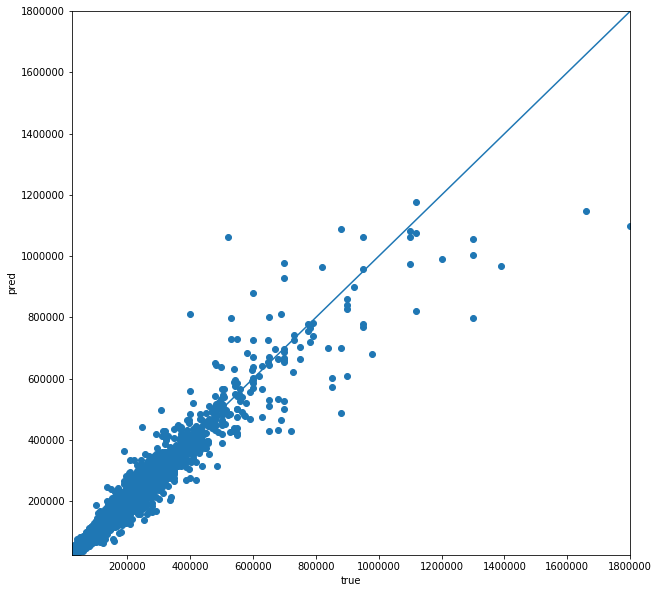

In [45]:
data = pd.concat([y_train, pd.Series(oof)], axis=1, ignore_index=True).rename(columns={0: 'true', 1: 'pred'})
plt.figure(figsize=(10,10))
plt.scatter(x='true',y='pred', data=data);
llim = data['true'].min() if data['true'].min() <= data['pred'].min() else data['pred'].min()
ulim = data['true'].max() if data['true'].max() >= data['pred'].max() else data['pred'].max()
plt.plot([llim, ulim], [llim, ulim])
plt.xlim((llim, ulim))
plt.ylim((llim, ulim))
plt.xlabel('true')
plt.ylabel('pred')
plt.show()

# 提出

In [46]:
lgb_reg = lgb.LGBMRegressor(**lgb_params)
lgb_reg.fit(X_train.values, y_train.values)

pred = lgb_reg.predict(X_test.values)

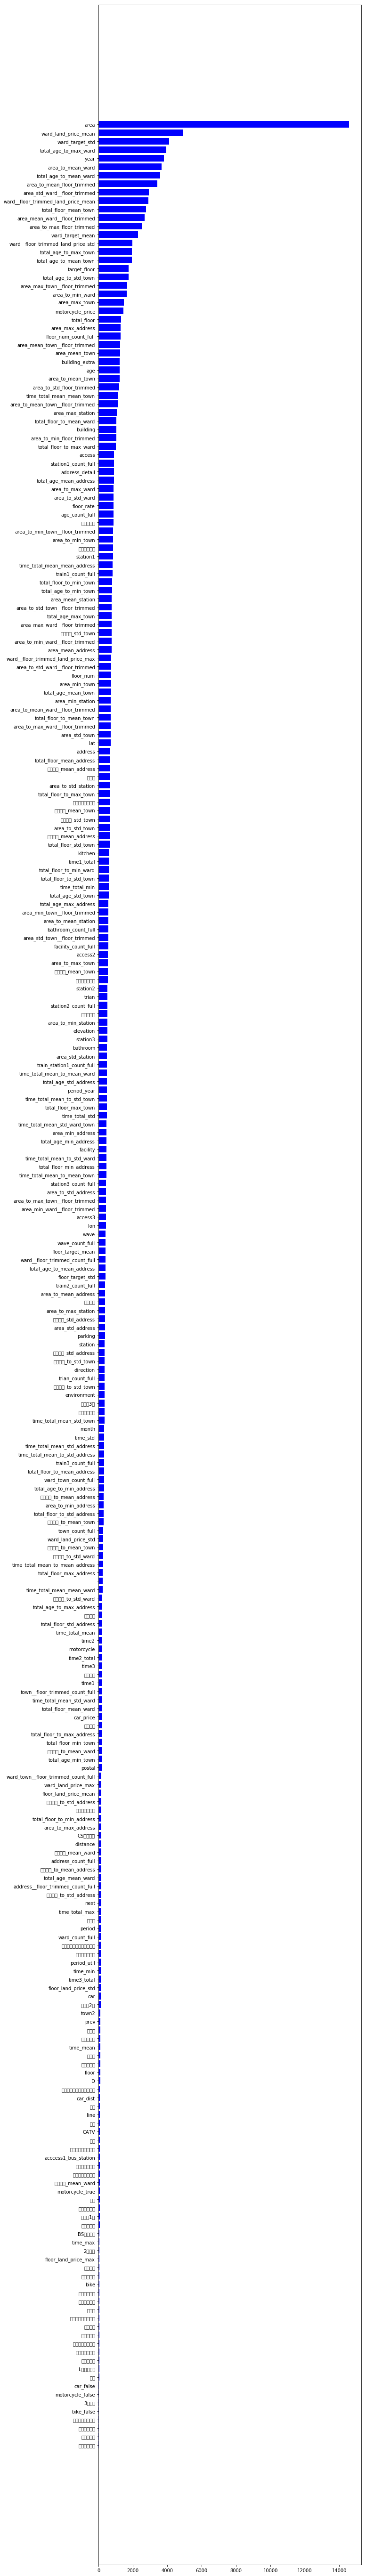

In [47]:
features = X_train.columns
importances = lgb_reg.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,100))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [48]:
#submission = pd.read_csv('./input/sample_submit.csv', header=None)
#submission[1] = pred
#submission.to_csv('./submission/submission30.csv', header=False, index=False)